# Montana AB Testing Scenario

The Library of Montana State University has a website that students use to find books and articles. This is what the homepage looks like:
Below the library picture, there is a search bar and three big items: “Find”, “Request” and “Interact”. All three of them contain access to important information and services that the library prides itself in offering. However, the Website Analytics show that the “Interact” button has, ironically, almost no interactions:

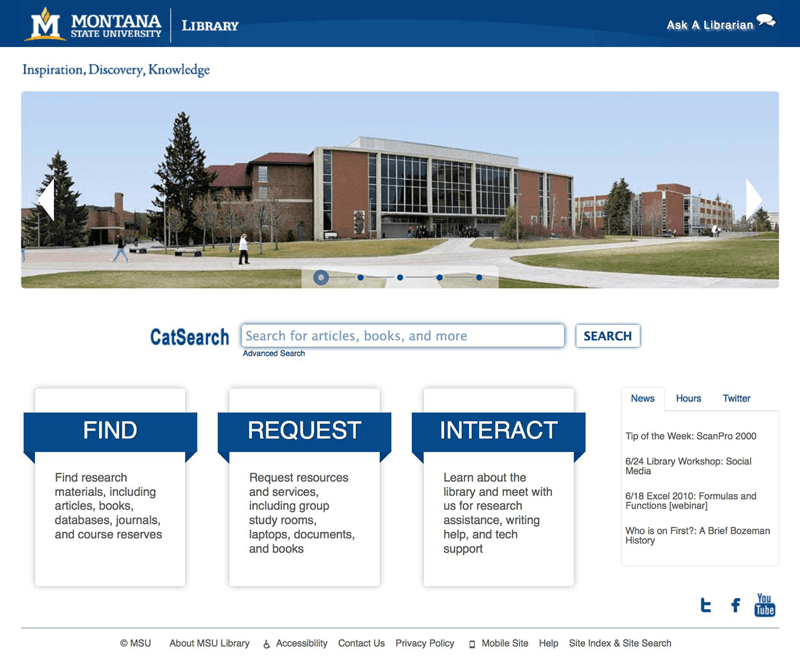!


The University therefore wants to improve the Headline of the category Interact.
An A/B Test is conducted:
- duration 21 days
- 5 Versions for the headline: Interact / Connect / Learn / Help / Services
- Measuresd primary KPI: CTR 
- second KPIs: drop off on category site /  Homepage return rate
- Minimum detectable effect: 30% in CTR


## Hypothesis

Null Hypothesis: There is no difference in CTR ctr for the 5 different headline versions
Alternative Hypothesis: There is a difference in the CTR in any of the 5 versions

## Data preparation

In [676]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [677]:
# set options
pd.options.mode.chained_assignment = None
pd.options.display.min_rows = 30
pd.options.display.max_rows = 100
pd.set_option("display.max_colwidth", 100)

In [678]:
# Import the result CSVs from the directory Data

sample1_int = pd.read_csv("Element_list_Homepage_Version_1_Interact.csv")
sample2_con = pd.read_csv("Element list Homepage Version 2-Connect.csv")
sample3_lea = pd.read_csv("Element list Homepage Version 3-Learn.csv")
sample4_he = pd.read_csv("Element list Homepage Version 4-Help.csv")
sample5_ser = pd.read_csv("Element list Homepage Version 5-Services.csv")

In [679]:
# Create an empty result Dataframe with all 5 samples 
results_df = pd.DataFrame(index = ["Visits","Clicks_on_version","No_clicks", "CTR",], columns=["Interact","Connect","Learn","Help","Services"])

In [680]:
# Collect the click results for the 5 different Labels from all samples
version_nums = []
version_nums.append(sample1_int.loc[(sample1_int.Name=="INTERACT")|(sample1_int.Name.str.contains("learn about the library",case=False)) ,"No. clicks"].sum())
version_nums.append(sample2_con.loc[(sample2_con.Name=="CONNECT")|(sample2_con.Name.str.contains("learn about the library",case=False)),"No. clicks"].sum())
version_nums.append(sample3_lea.loc[(sample3_lea.Name=="LEARN")|(sample3_lea.Name.str.contains("learn about the library",case=False)),"No. clicks"].sum())
version_nums.append(sample4_he.loc[(sample4_he.Name=="HELP")|(sample4_he.Name.str.contains("learn about the library",case=False)),"No. clicks"].sum())
version_nums.append(sample5_ser.loc[(sample5_ser.Name=="SERVICES")|(sample5_ser.Name.str.contains("learn about the library",case=False)),"No. clicks"].sum())


In [681]:
version_nums

[42, 55, 21, 38, 46]

In [682]:
#  Calculate the CTR and Total Clicks  for each version
ctrs = []
visits = [10283,2742,2747,3180,2069]
no_clicks =[]
for i in range(5):
    ctrs.append(round(version_nums[i]/visits[i],3))
    no_clicks.append(visits[i]-version_nums[i])


In [683]:
for i in range(5):
    results_df.iloc[0,i] = visits[i]
    results_df.iloc[1,i] = version_nums[i]
    results_df.iloc[2,i] = no_clicks[i]
    results_df.iloc[3,i] = ctrs[i] 

In [684]:
results_df

,Interact,Connect,Learn,Help,Services
Visits,10283,2742,2747,3180,2069
Clicks_on_version,42,55,21,38,46
No_clicks,10241,2687,2726,3142,2023
CTR,0.004,0.02,0.008,0.012,0.022


## Statistical evaluation 

In [686]:
# significance level is set to 10%
alpha = 0.1

In [687]:
# keep only teh click and no click information for Chi square
results_for_stats = results_df.iloc[1:3,:].copy()

In [688]:
results_for_stats

,Interact,Connect,Learn,Help,Services
Clicks_on_version,42,55,21,38,46
No_clicks,10241,2687,2726,3142,2023


In [689]:
chisq, pvalue,df,expected = stats.chi2_contingency(results_for_stats)

In [690]:
pvalue

3.642925661293395e-21

In [691]:
if pvalue < alpha:
    print("Reject the Null hypothesis")
else:
    print("The Null Hypothesis is valid")

Reject the Null hypothesis


The data indicates that there are significant differences in the click rate depending on the Headline used.
The best performer is Services with a CTR of 2.2%  Second best is Connect with a CTR of 2%

--> If there is a significant difference between the better performing Headlines needs to be evaluated in a second test

## Evaluation of pairs / Post hoc Test

10 Combinations are to evaluate
Interact  - Connect/Learn/Help/Services
Connect - Learn/Help/Services
Learn - Help/Services
Help - Services

In [695]:
# New Alpha defined by Bonferoni adjustment - alpha divided by number of subsets
subset_alpha = alpha/ 10

In [696]:
#create a new dataframe with all pairs to evaluate
subsets_df = pd.DataFrame(index=["Interact","Connect","Learn","Help","Services"], columns = ["Interact","Connect","Learn","Help","Services"])

In [697]:
results_dict = {"Interact": [],"Connect": [],"Learn": [],"Help": [], "Services": []}

for i in results_for_stats.columns:
    for j in results_for_stats.columns:
        if j != i:
            chisq,pval,dfr,expect = stats.chi2_contingency(results_for_stats.loc[:,[i,j]])
            results_dict[i].append(pval < subset_alpha)
        else:
            results_dict[i].append("-")


In [698]:
results_dict

{'Interact': ['-', True, False, True, True],
 'Connect': [True, '-', True, False, False],
 'Learn': [False, True, '-', False, True],
 'Help': [True, False, False, '-', True],
 'Services': [True, False, True, True, '-']}

In [699]:
results_pairs_df = pd.DataFrame(results_dict, index=["Interact","Connect","Learn","Help","Services"])

results_pairs_df.loc[len(results_pairs_df)] =ctrs
results_pairs_df.index =["Interact","Connect","Learn","Help","Services","CTRs"]

In [700]:
results_pairs_df

,Interact,Connect,Learn,Help,Services
Interact,-,True,False,True,True
Connect,True,-,True,False,False
Learn,False,True,-,False,True
Help,True,False,False,-,True
Services,True,False,True,True,-
CTRs,0.004,0.02,0.008,0.012,0.022


Services with the best CTR is significant different versus Interact, Learn and Help --> There is no sifnicant difference found versus Connect
Connect is significantly different to Interact and Learn

Since those two have the best CTR and are not very different to each other the next step is to evaluate the second KPI Drop-Off-Rate  

## Drop off Rates
- not collected for HELP 

In [703]:
droprates = {"Interact":10,"Connect":6,"Learn":3,"Services":0}
droprates_df = pd.DataFrame(data=droprates, index=["drop_rates"])

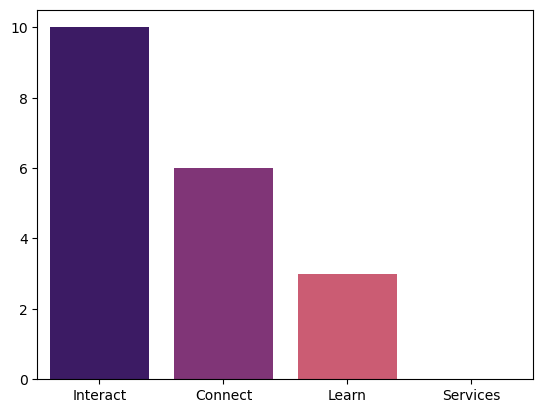

In [704]:
sns.barplot(data=droprates_df, palette="magma");

**Services is the headline with the lowest drop rate, that indicates users find the contents they are expecting in the category**